c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4764/4764 ━━━━━━━━━━━━━━━━━━━━ 97s 20ms/step - loss: 0.0048
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


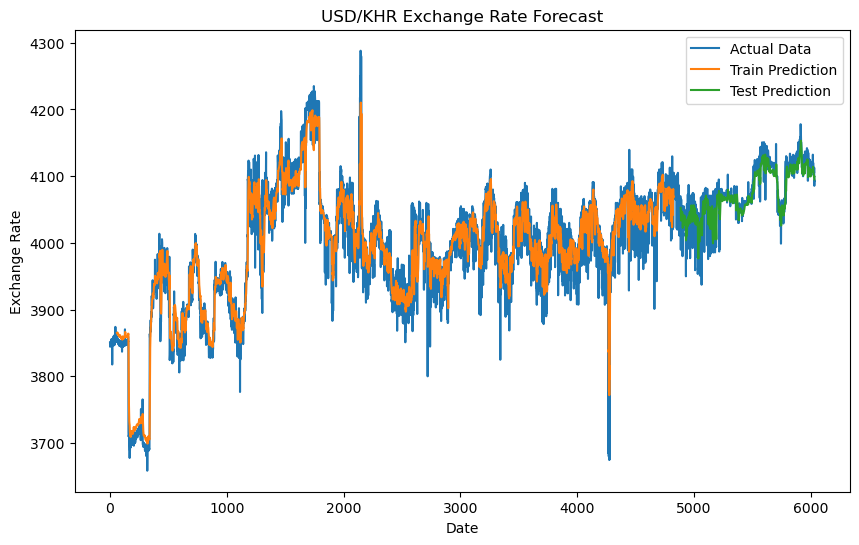

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the data
data = pd.read_csv('usd-khr.csv', index_col='Date', parse_dates=True, dayfirst=True)

# Preprocess the data
data = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
  
# Prepare the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Data')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.title('USD/KHR Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()